In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from bidict import bidict
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

In [2]:
ENCODER = bidict({
    'a': 0, 
    'e_i' : 1,
    'o_u': 2
})

In [3]:
labels = np.load("../data/labels.npy")
labels = labels - 1
labels.shape

(496,)

In [4]:
imgs = np.load("../data/imgs.npy").astype("float32") / 255

In [5]:
# check out one of the images
# plt.figure()
# plt.imshow(imgs[0])
# plt.grid(False)
# plt.show()

In [6]:
if imgs.ndim == 3:
    imgs = np.expand_dims(imgs, -1)

In [7]:
imgs_train, imgs_test, labels_train, labels_test = train_test_split(
    imgs, labels, test_size=0.30, stratify=labels, random_state=42
)

In [8]:
print(imgs_train.shape)
print(labels_train.shape)

print(labels_train.min())
print(labels_train.max())

(347, 28, 28, 1)
(347,)
0
2


In [9]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1
)
datagen.fit(imgs_train)

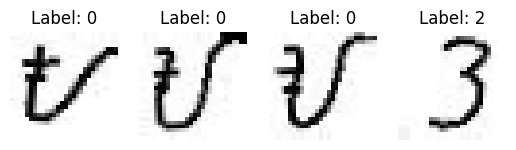

In [10]:
for x_batch, y_batch in datagen.flow(imgs_train, labels_train, batch_size=4):
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.imshow(x_batch[i].squeeze(), cmap='gray')
        plt.title(f"Label: {y_batch[i]}")
        plt.axis('off')
    plt.show()
    break

In [11]:
batch_size = 8
epochs = 30

model = keras.Sequential([
    keras.Input(shape=(28, 28, 1)),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4, restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=2
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    verbose=1,
    min_lr=1e-6
)

early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
# checkpoint = ModelCheckpoint("best_model.keras", monitor="val_accuracy", save_best_only=True)

optimizer = keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels_train),
    y=labels_train
)

class_weight_dict = dict(enumerate(class_weights))

model.fit(
    datagen.flow(imgs_train, labels_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(imgs_test, labels_test),
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weight_dict
)

Epoch 1/30


C:\Users\ASUS\Desktop\baybayin-ml\venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3345 - loss: 1.1063 - val_accuracy: 0.3289 - val_loss: 1.0994 - learning_rate: 0.0010
Epoch 2/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3291 - loss: 1.1019 - val_accuracy: 0.3758 - val_loss: 1.0985 - learning_rate: 0.0010
Epoch 3/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2956 - loss: 1.1045 - val_accuracy: 0.3289 - val_loss: 1.0985 - learning_rate: 0.0010
Epoch 4/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3061 - loss: 1.0948 - val_accuracy: 0.3289 - val_loss: 1.0984 - learning_rate: 0.0010
Epoch 5/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3627 - loss: 1.0866 - val_accuracy: 0.3758 - val_loss: 1.0984 - learning_rate: 0.0010
Epoch 6/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3488 - loss: 1.0971 - val_accuracy: 0.3758 - val_loss: 1.0981 - learning_rate: 0.0010
Epoch 7/30
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3248 - loss: 1.0999 - val_accuracy: 0.2953 - v

32 128-3-2 256-3-2 .9102
32 256-3-2 128-3-2 .9077
32 128-3-2 256-3-2 512-3-2 .9127
32 128-1-2 256-3-2 512-5-2 .9327
32 128-5-2 256-5-2 512-5-2 .9626

In [14]:
model.evaluate(imgs_test, labels_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3505 - loss: 1.0983 


[1.0981438159942627, 0.3758389353752136]

In [15]:
import numpy as np

sample_imgs = imgs_test[:5]
sample_labels = labels_test[:5]

preds = model.predict(sample_imgs)
predicted_classes = np.argmax(preds, axis=1)

print("Predicted:", predicted_classes)
print("Actual:   ", sample_labels)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted: [0 0 0 0 0]
Actual:    [2 0 0 2 2]


In [16]:
import numpy as np
from collections import Counter

print("Train:", Counter(labels_train))
print("Test:", Counter(labels_test))

Train: Counter({np.int64(0): 129, np.int64(2): 116, np.int64(1): 102})
Test: Counter({np.int64(0): 56, np.int64(2): 49, np.int64(1): 44})


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


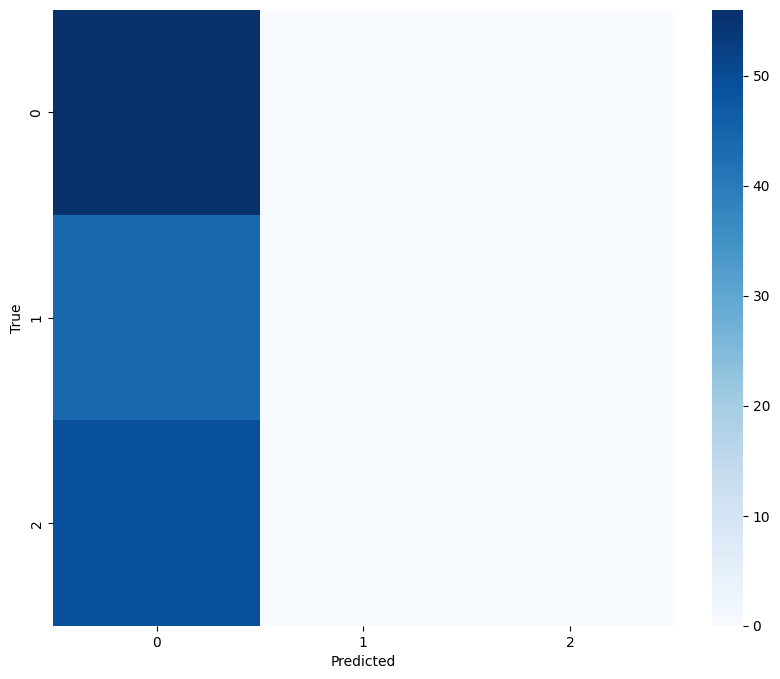

In [17]:
y_pred = model.predict(imgs_test).argmax(axis=1)
cm = confusion_matrix(labels_test, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


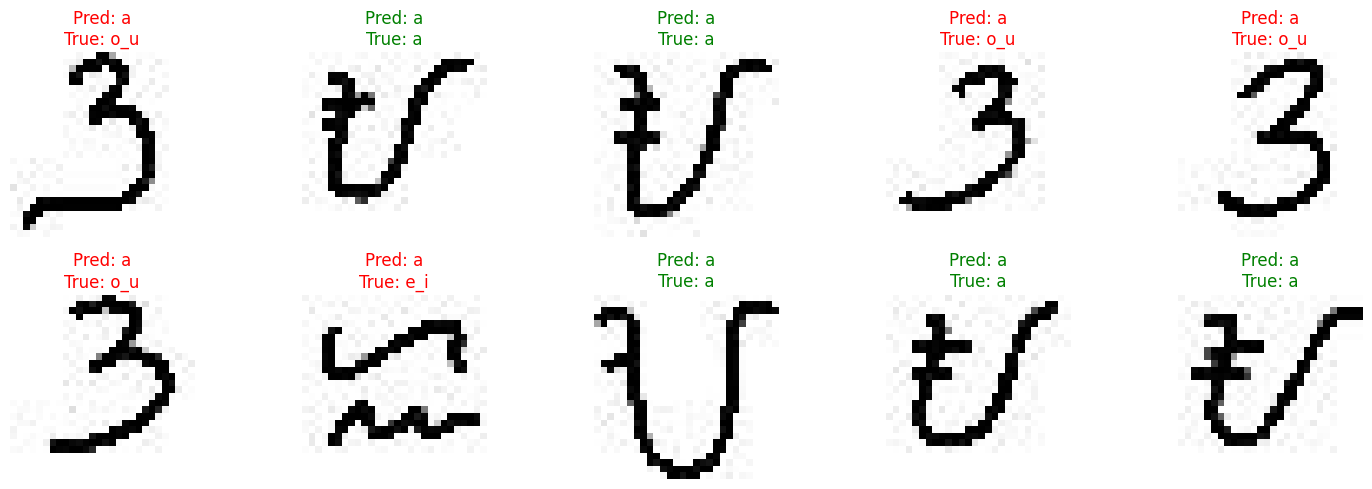

In [18]:
import matplotlib.pyplot as plt

# Predict on test set
preds = model.predict(imgs_test)
pred_labels = np.argmax(preds, axis=1)

# Number of samples to show
num_samples = 10

# Inverse mapping from label to character
inv_encoder = {v: k for k, v in ENCODER.items()}

plt.figure(figsize=(15, 5))

for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(imgs_test[i].squeeze(), cmap='gray')
    plt.axis('off')
    
    actual = inv_encoder[labels_test[i]]
    predicted = inv_encoder[pred_labels[i]]
    
    color = 'green' if actual == predicted else 'red'
    plt.title(f"Pred: {predicted}\nTrue: {actual}", color=color)

plt.tight_layout()
plt.show()

In [ ]:
misclassified = np.where(y_pred != labels_test)[0]
for i in misclassified[:5]:  # show first 5 [:x}
    plt.imshow(imgs_test[i].squeeze(), cmap='gray') 
    
    true_char = ENCODER.inverse[labels_test[i] + 1]
    pred_char = ENCODER.inverse[y_pred[i] + 1]
    
    plt.title(f"True: {true_char}, Pred: {pred_char}")
    plt.axis('off')
    plt.show()

In [ ]:
model.summary()

In [ ]:
unique, counts = np.unique(labels_train, return_counts=True)
for u, c in zip(unique, counts):
    print(f"Label {u}: {c} samples")

In [ ]:
model.save("baybayin_model_v3.keras")

In [ ]:
print(f"Num classes: {len(np.unique(labels))}")
print(f"Min label: {np.min(labels)}, Max label: {np.max(labels)}")

In [ ]:
import collections
print(collections.Counter(labels_train))

In [ ]:
for i in range(10):
    sample = imgs_test[i].reshape(1, 50, 50, 1)
    pred = np.argmax(model.predict(sample), axis=-1)[0]
    true = labels_test[i]
    print(f"True: {true}, Pred: {pred}")